In [1]:
import numpy as np
import torch
from torch import Tensor, nn
import torch.utils.data as data_utils
from torch.distributions import Distribution
from torch.distributions import Bernoulli
from typing import *
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import Image, display, clear_output
import numpy as np
import seaborn as sns
import pandas as pd
import math 
import torch
from torch.nn.functional import softplus
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from collections import defaultdict


sns.set_style("whitegrid")
"""from google.colab import drive
drive.mount('/content/drive')
!ls drive/'My Drive/YYY_deep_project_YYY'"""

"from google.colab import drive\ndrive.mount('/content/drive')\n!ls drive/'My Drive/YYY_deep_project_YYY'"

In [2]:
#%cd drive/'My Drive/YYY_deep_project_YYY'

In [3]:
def get_sequence(infile):

    while True:

        header = infile.readline()
        sequence = infile.readline()

        pdb = header[1:5]

        if not header or not sequence or set(sequence) == {'X'}:
            return
        
        yield header.strip()[1:], sequence.strip(), pdb

120


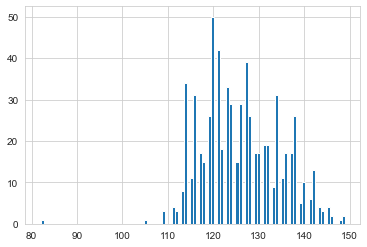

In [4]:
sequences = []
pdb_to_seq = {}
count = 0
with open('all_heavy.fasta') as infile:

        for header, sequence, pdb in get_sequence(infile):
            sequences.append(list(sequence))            
            pdb_to_seq[pdb.lower()] = sequence
            
sequences = [seq for seq in sequences if len(seq) < 150]

lengths = [len(seq) for seq in sequences]

mode = max(set(lengths), key=lengths.count)
print(mode)

plt.hist(lengths, bins=100)
plt.show()

In [5]:
df = pd.read_csv('sabdab_summary_all-2.tsv', sep='\t')
df = df[['pdb', 'affinity']]
df['sequence'] = df['pdb'].map(pdb_to_seq)
df = df.loc[~df['sequence'].isna()]
df = df.loc[df['sequence'].str.strip('-').str.len() < 300]
print(len(df))

df['affinity'] = [float(aff) if aff != 'None' else np.NaN for aff in df['affinity']]
labelled = df.dropna()
unlabelled = df.loc[df['affinity'].isnull()]

print(len(labelled), len(unlabelled))

6548
1088 5460


In [6]:
# make binder column for labelled data
labelled['binder'] = (labelled.affinity < 500*10**(-9)).astype(int)
print(labelled.binder.value_counts())

1    948
0    140
Name: binder, dtype: int64


<ipython-input-6-bdf718d4123b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labelled['binder'] = (labelled.affinity < 500*10**(-9)).astype(int)


In [7]:
from torch.utils import data
from random import shuffle


class Dataset(data.Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets

    def __len__(self):
        # Return the size of the dataset
        return len(self.targets)

    def __getitem__(self, index):
        # Retrieve inputs and targets at the given index
        X = self.inputs[index]
        y = self.targets[index]

        return X, y

def create_datasets(sequences, targets, dataset_class, p_train=0.8, p_val=0.1, p_test=0.1):
    
    # Define partition sizes
    num_train = int(len(sequences)*p_train)
    num_val = int(len(sequences)*p_val)
    num_test = int(len(sequences)*p_test)

    # Split sequences into partitions
    sequences_train = sequences[:num_train-1]
    targets_train = targets[:num_train-1]
    
    # add reversed sequences for training and shuffle
    #sequences_train += [seq[::-1] for seq in sequences_train]
    #shuffle(sequences_train)

    sequences_val = sequences[num_train:num_train+num_val-1]
    targets_val = targets[num_train:num_train+num_val-1]

    sequences_test = sequences[-num_test:-1]
    targets_test = targets[-num_test:-1]
    
    
    input_train = [['<sos>'] + list(seq)+['<eos>'] for seq in sequences_train]
    input_val = [['<sos>'] + list(seq)+['<eos>'] for seq in sequences_val]
    input_test = [['<sos>'] + list(seq)+['<eos>'] for seq in sequences_test]


    
    return (input_train, targets_train), (input_val, targets_val), (input_test, targets_test)


(input_train, targets_train), (input_val, targets_val), (input_test, targets_test) = create_datasets(labelled['sequence'].tolist(), labelled['binder'].tolist(), Dataset)

In [8]:
print('Samples for training:', len(input_train), len(targets_train))
print('Samples for validation:', len(input_val), len(targets_val))
print('Samples for testing:', len(input_test), len(targets_test))

Samples for training: 869 869
Samples for validation: 107 107
Samples for testing: 107 107


In [9]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence


class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)
    

class TransformerModel(nn.Module):

    def __init__(self, ntoken, ninp, nhead, nhid, nlayers, dropout=0.5):
        super(TransformerModel, self).__init__()
        
        from torch.nn import TransformerEncoder, TransformerEncoderLayer, TransformerDecoder, TransformerDecoderLayer
        
        self.model_type = 'Transformer'
        
        self.pos_encoder = PositionalEncoding(ninp, dropout)

        encoder_layers = TransformerEncoderLayer(ninp, nhead, nhid, dropout)
        self.t_encoder = TransformerEncoder(encoder_layers, nlayers)
        
        self.embed = nn.Embedding(ntoken, ninp)
        self.ninp = ninp
        
        decoder_layers = TransformerDecoderLayer(ninp, nhead, nhid, dropout)
        self.t_decoder = TransformerDecoder(decoder_layers, nlayers)

        # neuron per aa
        #self.ff = nn.Linear(ninp, ntoken)
        
        # "classification layer" - two neurons
        self.ff_out = nn.Linear(ninp, 2)
        #self.ff_out = nn.Linear(ntoken, 2)

        self._init_weights()
        

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float(-1e-10)).masked_fill(mask == 1, float(0.0))
        
        return mask

 
    def _init_weights(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)
       

    def forward(self, src, src_mask, tgt, tgt_mask, mem_pad_mask=None):
        

        embeds = self.embed(src) * math.sqrt(self.ninp)
        
        positions = self.pos_encoder(embeds)
    
        
        encoded = self.t_encoder(positions)

        embeds = self.embed(tgt)
        positions = self.pos_encoder(embeds)

        print(positions.shape, encoded.shape, tgt_mask.shape)
        decoded = self.t_decoder(tgt=positions, memory=encoded, tgt_mask=tgt_mask)
  
        #out = self.ff(decoded)
        
        output_class = F.softmax(self.ff_out(decoded),dim=1)

        return output_class


In [10]:
def one_hot_encode(idx, num_classes):
    # Initialize the encoded array
    one_hot = np.zeros(num_classes)
    
    # Set the appropriate element to one
    one_hot[idx] = 1.0

    return one_hot


In [57]:
vocab = ['<pad>', "<sos>", "<eos>"] + ["A","C","D","E","F","G","H","I","K","L","M","N","P","Q","R","S","T","V","W","X","Y"]
char_nums = {token:vocab.index(token) for token in vocab}

def batchify(sources, targets, max_len):
    # convert to respective aa ids
    sources_numeric = [[char_nums[char] for char in seq] for seq in sources]
    
    seq_lengths = torch.LongTensor([len(seq) for seq in sources])

    # dump padding everywhere, and place seqs on the left.
    # you need a tensor as big as your longest sequence
    src_tensor = torch.zeros((len(sources_numeric), max_len)).long()
    
    for idx, (seq, seqlen) in enumerate(zip(sources_numeric, seq_lengths)):
        src_tensor[idx, :(seqlen)] = torch.LongTensor(seq)
    
    # convert target to long tensor
    print(targets)
    targets_one_hot = [one_hot_encode(tgt,2) for tgt in targets]
    tgt_tensor = torch.LongTensor(targets_one_hot)
    print(tgt_tensor)
    
    
    # SORT YOUR TENSORS BY LENGTH!
    #seq_lengths, perm_idx = seq_lengths.sort(0, descending=True)
    #src_tensor = src_tensor[perm_idx]
    #tgt_tensor = tgt_tensor[perm_idx]

    return src_tensor, tgt_tensor

seq_lengths = torch.LongTensor([len(seq) for seq in labelled['sequence'].tolist()])
max_len = int(seq_lengths.max() +2)    # plus 2 for <sos> and <eos>

(train_src, train_tgt) = batchify(input_train, targets_train, max_len)
(val_src, val_tgt) = batchify(input_val, targets_val, max_len)
(test_src, test_tgt) = batchify(input_test, targets_test, max_len)

print(train_src.shape, train_tgt.shape)
print(test_src.shape, test_tgt.shape)

[1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 

<ipython-input-57-27c4645baf67>:20: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  tgt_tensor = torch.LongTensor(targets_one_hot)


In [12]:
bptt = 50
eval_bptt = 50

def get_batch(sources, targets, idx, bsz):
    n_seqs = min(bsz, len(sources) - idx)
    
    max_len = max([len(seq) for seq in sources])
    
    src = torch.cat([sources[i] for i in range(idx, n_seqs+idx)]).view(n_seqs, max_len)
        
    target = torch.cat([targets[i] for i in range(idx, n_seqs+idx)]).view(n_seqs,2) #.reshape(-1)
    
    return src, target


In [13]:
ntokens = len(vocab) # the size of vocabulary
nhid = 40 # the dimension of the feedforward network model in nn.TransformerEncoder
emsize = 2*nhid # embedding dimension
nlayers = 6 # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 8 # the number of heads in the multiheadattention models
dropout = 0 # the dropout value

In [17]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
#device = "cpu"
#torch.cuda.empty_cache()

#  ntoken, ninp, nhead, nhid, nlayers, dropout=0.5):
model = TransformerModel(ntokens, emsize, nhead, nhid, nlayers, dropout).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=0)
#lr = 0.05 # learning rate, SGD
lr = 0.00001 # learning rate, Adam
#optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.4)
optimizer  = torch.optim.Adam(lr=lr, params=model.parameters(), weight_decay=0.2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.99)

train_losses = []
val_losses = []
model.to(device)
import sys
import time
def train():
    
    train_loss = 0
    
    n_batches = 0
    
    model.train() # Turn on the train mode
    total_loss = 0.
    start_time = time.time()
    ntokens = len(vocab)
    src_mask = model.generate_square_subsequent_mask(bptt).to(device)
    
    for batch, idx in enumerate(range(0, train_src.size(0) - 1, bptt)):
        
        data, targets = get_batch(train_src, train_tgt, idx, bptt)
        data, targets = data.to(device), targets.to(device)
        if data.shape[0] < bptt:
          break
        
        optimizer.zero_grad()
        
        src_mask = model.generate_square_subsequent_mask(data.size(0)).to(device)
        #src_pad_mask = (data == 0).bool().view(data.size(1), data.size(0))
        
        tgt_mask = model.generate_square_subsequent_mask(targets.size(0)).to(device)
        #tgt_pad_mask = (targets == 0).bool().view(targets.size(1), targets.size(0))
        
        output = model(data, src_mask, targets, tgt_mask)

        #output_trans = output.view(-1, ntokens)
        #target_trans = targets.view(-1, targets.size(1) * targets.size(0)).squeeze(0) 

        loss = criterion(output, targets)
        
        n_batches += 1
        train_loss += loss
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        
        # Soft, hard accuracy
        #o = list(output.view(-1, ntokens)[0])
        #t = targets
        #print(o,t)
        #hard_acc = sum([i for i in range(len(targets)) if o[i] == t[i]])/len(targets)
        
        optimizer.step()
        
        total_loss += loss.item()
        log_interval = 1
        if batch % log_interval == 0 and batch > 0:
            cur_loss = total_loss / log_interval
            
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | '
                  'lr {:8f} | ms/batch {:5.2f} | '
                  'loss {:8f} | ppl {:8f}|'.format(
                    epoch, batch, len(train_src) // bptt, scheduler.get_lr()[0],
                    elapsed * 1000 / log_interval,
                    cur_loss, math.exp(cur_loss)))
            total_loss = 0
            start_time = time.time()
    
    train_losses.append(train_loss/n_batches)

def evaluate(eval_model, src, tgt):
    eval_model.eval() # Turn on the evaluation mode
    total_loss = 0.
    
    src_mask = model.generate_square_subsequent_mask(bptt).to(device)
    
    with torch.no_grad():
        for idx in range(0, src.size(0) - 1, eval_bptt):
            data, targets = get_batch(src, tgt, idx, eval_bptt)
            data, targets = data.to(device), targets.to(device)
            if data.shape[0] < eval_bptt:
                break

            src_mask = model.generate_square_subsequent_mask(data.size(0)).to(device)
            #src_pad_mask = (data == 0).bool().view(data.size(1), data.size(0))
        
            tgt_mask = model.generate_square_subsequent_mask(targets.size(0)).to(device)
            #tgt_pad_mask = (targets == 0).bool().view(targets.size(1), targets.size(0))    
            
            output = eval_model(data, src_mask, targets, tgt_mask)#, src_pad_mask, tgt_pad_mask)
            
            #output_trans = output.view(-1, ntokens)
            #target_trans = targets.view(-1, targets.size(1) * targets.size(0)).squeeze(0)
            
            total_loss += len(data) * criterion(output, targets).item()
            
    return total_loss / (len(src) - 1)


In [18]:
best_val_loss = float("inf")
epochs = 200 # The number of epochs
best_model = None

for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    train()
    val_loss = evaluate(model, val_src, val_tgt)
    val_losses.append(val_loss)
    print('-' * 89)
    print('| end of epoch {:3d} | time: {:5.2f}s | valid loss {:8f} | '
          'valid ppl {:8f}'.format(epoch, (time.time() - epoch_start_time),
                                     val_loss, math.exp(val_loss)))
    print('-' * 89)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model

    scheduler.step()

torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch   1 |     1/   17 batches | lr 0.000010 | ms/batch 313.07 | loss 1.383555 | ppl 3.989059|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch   1 |     2/   17 batches | lr 0.000010 | ms/batch 145.03 | loss 0.692934 | ppl 1.999573|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch   1 |     3/   17 batches | lr 0.000010 | ms/batch 147.03 | loss 0.693706 | ppl 2.001119|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch   1 |     4/   17 batches | lr 0.000010 | ms/batch 138.03 | loss 0.693978 | ppl 2.001662|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch   1 |     5/   17 batches | lr 0.000010 | ms/batch 142.03 | loss 0.692778 | ppl 1.999263|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch   1 |

| epoch   3 |    12/   17 batches | lr 0.000010 | ms/batch 143.03 | loss 0.686517 | ppl 1.986783|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch   3 |    13/   17 batches | lr 0.000010 | ms/batch 138.03 | loss 0.684586 | ppl 1.982952|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch   3 |    14/   17 batches | lr 0.000010 | ms/batch 136.03 | loss 0.685263 | ppl 1.984293|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch   3 |    15/   17 batches | lr 0.000010 | ms/batch 138.03 | loss 0.681941 | ppl 1.977713|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch   3 |    16/   17 batches | lr 0.000010 | ms/batch 138.03 | loss 0.682976 | ppl 1.979760|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
------------------------------------------------------------------------------------

| epoch   6 |     6/   17 batches | lr 0.000009 | ms/batch 143.03 | loss 0.675406 | ppl 1.964830|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch   6 |     7/   17 batches | lr 0.000009 | ms/batch 136.03 | loss 0.678009 | ppl 1.969951|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch   6 |     8/   17 batches | lr 0.000009 | ms/batch 141.03 | loss 0.673541 | ppl 1.961169|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch   6 |     9/   17 batches | lr 0.000009 | ms/batch 142.03 | loss 0.676419 | ppl 1.966823|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch   6 |    10/   17 batches | lr 0.000009 | ms/batch 141.03 | loss 0.676384 | ppl 1.966753|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch   6 |    11/   17 batches | lr 0.000009 | ms/batch 141.03 | loss 0.675617 | ppl 1.965245|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.S

torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
-----------------------------------------------------------------------------------------
| end of epoch   8 | time:  2.54s | valid loss 0.631537 | valid ppl 1.880499
-----------------------------------------------------------------------------------------
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch   9 |     1/   17 batches | lr 0.000009 | ms/batch 277.06 | loss 1.331258 | ppl 3.785804|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch   9 |     2/   17 batches | lr 0.000009 | ms/batch 740.17 | loss 0.669688 | ppl 1.953628|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch   9 |     3/   17 batches | lr 0.000009 | ms/batch 140.03 | loss 0.667158 | ppl 1.948692|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch   9 |     4/   

| epoch  11 |    10/   17 batches | lr 0.000009 | ms/batch 140.03 | loss 0.660013 | ppl 1.934818|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  11 |    11/   17 batches | lr 0.000009 | ms/batch 141.03 | loss 0.658145 | ppl 1.931206|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  11 |    12/   17 batches | lr 0.000009 | ms/batch 144.03 | loss 0.661800 | ppl 1.938277|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  11 |    13/   17 batches | lr 0.000009 | ms/batch 143.03 | loss 0.652493 | ppl 1.920321|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  11 |    14/   17 batches | lr 0.000009 | ms/batch 141.03 | loss 0.660252 | ppl 1.935280|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  11 |    15/   17 batches | lr 0.000009 | ms/batch 139.03 | loss 0.659825 | ppl 1.934455|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.S

| epoch  14 |     4/   17 batches | lr 0.000009 | ms/batch 140.03 | loss 0.644312 | ppl 1.904677|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  14 |     5/   17 batches | lr 0.000009 | ms/batch 139.03 | loss 0.645904 | ppl 1.907712|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  14 |     6/   17 batches | lr 0.000009 | ms/batch 141.03 | loss 0.649823 | ppl 1.915202|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  14 |     7/   17 batches | lr 0.000009 | ms/batch 138.03 | loss 0.652247 | ppl 1.919850|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  14 |     8/   17 batches | lr 0.000009 | ms/batch 140.03 | loss 0.641292 | ppl 1.898933|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  14 |     9/   17 batches | lr 0.000009 | ms/batch 139.03 | loss 0.647651 | ppl 1.911046|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.S

| epoch  16 |    16/   17 batches | lr 0.000009 | ms/batch 141.03 | loss 0.637592 | ppl 1.891919|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
-----------------------------------------------------------------------------------------
| end of epoch  16 | time:  2.46s | valid loss 0.603005 | valid ppl 1.827602
-----------------------------------------------------------------------------------------
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  17 |     1/   17 batches | lr 0.000008 | ms/batch 281.06 | loss 1.270023 | ppl 3.560934|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  17 |     2/   17 batches | lr 0.000008 | ms/batch 140.03 | loss 0.641279 | ppl 1.898908|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  17 |     3/   

| epoch  19 |    10/   17 batches | lr 0.000008 | ms/batch 141.03 | loss 0.624720 | ppl 1.867722|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  19 |    11/   17 batches | lr 0.000008 | ms/batch 139.03 | loss 0.623045 | ppl 1.864598|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  19 |    12/   17 batches | lr 0.000008 | ms/batch 141.03 | loss 0.630998 | ppl 1.879486|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  19 |    13/   17 batches | lr 0.000008 | ms/batch 143.03 | loss 0.611151 | ppl 1.842551|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  19 |    14/   17 batches | lr 0.000008 | ms/batch 137.03 | loss 0.627594 | ppl 1.873098|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  19 |    15/   17 batches | lr 0.000008 | ms/batch 141.03 | loss 0.633507 | ppl 1.884207|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.S

| epoch  22 |     4/   17 batches | lr 0.000008 | ms/batch 146.03 | loss 0.603810 | ppl 1.829073|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  22 |     5/   17 batches | lr 0.000008 | ms/batch 141.03 | loss 0.606587 | ppl 1.834161|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  22 |     6/   17 batches | lr 0.000008 | ms/batch 145.03 | loss 0.617930 | ppl 1.855083|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  22 |     7/   17 batches | lr 0.000008 | ms/batch 138.03 | loss 0.619331 | ppl 1.857685|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  22 |     8/   17 batches | lr 0.000008 | ms/batch 140.03 | loss 0.599485 | ppl 1.821181|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  22 |     9/   17 batches | lr 0.000008 | ms/batch 140.03 | loss 0.610793 | ppl 1.841891|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.S

| epoch  24 |    15/   17 batches | lr 0.000008 | ms/batch 140.03 | loss 0.613694 | ppl 1.847242|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  24 |    16/   17 batches | lr 0.000008 | ms/batch 139.03 | loss 0.600488 | ppl 1.823007|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
-----------------------------------------------------------------------------------------
| end of epoch  24 | time:  2.48s | valid loss 0.567121 | valid ppl 1.763184
-----------------------------------------------------------------------------------------
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  25 |     1/   17 batches | lr 0.000008 | ms/batch 281.06 | loss 1.194546 | ppl 3.302057|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  25 |     2/   

| epoch  27 |     8/   17 batches | lr 0.000008 | ms/batch 140.03 | loss 0.571059 | ppl 1.770140|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  27 |     9/   17 batches | lr 0.000008 | ms/batch 145.03 | loss 0.585418 | ppl 1.795741|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  27 |    10/   17 batches | lr 0.000008 | ms/batch 145.03 | loss 0.583606 | ppl 1.792491|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  27 |    11/   17 batches | lr 0.000008 | ms/batch 137.03 | loss 0.582330 | ppl 1.790204|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  27 |    12/   17 batches | lr 0.000008 | ms/batch 139.03 | loss 0.593915 | ppl 1.811065|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  27 |    13/   17 batches | lr 0.000008 | ms/batch 140.03 | loss 0.563775 | ppl 1.757293|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.S

torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  30 |     1/   17 batches | lr 0.000007 | ms/batch 284.06 | loss 1.143846 | ppl 3.138818|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  30 |     2/   17 batches | lr 0.000007 | ms/batch 138.03 | loss 0.582837 | ppl 1.791113|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  30 |     3/   17 batches | lr 0.000007 | ms/batch 138.03 | loss 0.567464 | ppl 1.763788|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  30 |     4/   17 batches | lr 0.000007 | ms/batch 141.03 | loss 0.559414 | ppl 1.749647|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  30 |     5/   17 batches | lr 0.000007 | ms/batch 140.03 | loss 0.563120 | ppl 1.756142|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  30 |     6/   17 batches | lr 0.000007 | ms/batch 141.03 | loss 0.581308 | 

| epoch  32 |    12/   17 batches | lr 0.000007 | ms/batch 145.03 | loss 0.570060 | ppl 1.768373|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  32 |    13/   17 batches | lr 0.000007 | ms/batch 140.03 | loss 0.534739 | ppl 1.707002|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  32 |    14/   17 batches | lr 0.000007 | ms/batch 141.03 | loss 0.566320 | ppl 1.761771|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  32 |    15/   17 batches | lr 0.000007 | ms/batch 140.03 | loss 0.579806 | ppl 1.785692|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  32 |    16/   17 batches | lr 0.000007 | ms/batch 138.03 | loss 0.559653 | ppl 1.750066|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
------------------------------------------------------------------------------------

| epoch  35 |     6/   17 batches | lr 0.000007 | ms/batch 140.03 | loss 0.557785 | ppl 1.746800|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  35 |     7/   17 batches | lr 0.000007 | ms/batch 139.03 | loss 0.558868 | ppl 1.748691|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  35 |     8/   17 batches | lr 0.000007 | ms/batch 140.03 | loss 0.525026 | ppl 1.690502|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  35 |     9/   17 batches | lr 0.000007 | ms/batch 140.03 | loss 0.545737 | ppl 1.725880|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  35 |    10/   17 batches | lr 0.000007 | ms/batch 143.03 | loss 0.542115 | ppl 1.719641|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  35 |    11/   17 batches | lr 0.000007 | ms/batch 142.03 | loss 0.539656 | ppl 1.715417|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.S

torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  38 |     1/   17 batches | lr 0.000007 | ms/batch 286.06 | loss 1.059457 | ppl 2.884803|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  38 |     2/   17 batches | lr 0.000007 | ms/batch 139.03 | loss 0.542397 | ppl 1.720125|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  38 |     3/   17 batches | lr 0.000007 | ms/batch 142.03 | loss 0.524336 | ppl 1.689337|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  38 |     4/   17 batches | lr 0.000007 | ms/batch 140.03 | loss 0.514270 | ppl 1.672417|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  38 |     5/   17 batches | lr 0.000007 | ms/batch 140.03 | loss 0.518468 | ppl 1.679453|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  38 |     6/   17 batches | lr 0.000007 | ms/batch 141.03 | loss 0.542429 | 

| epoch  40 |    12/   17 batches | lr 0.000007 | ms/batch 144.03 | loss 0.530079 | ppl 1.699066|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  40 |    13/   17 batches | lr 0.000007 | ms/batch 139.03 | loss 0.486663 | ppl 1.626878|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  40 |    14/   17 batches | lr 0.000007 | ms/batch 138.03 | loss 0.525616 | ppl 1.691500|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  40 |    15/   17 batches | lr 0.000007 | ms/batch 143.03 | loss 0.542917 | ppl 1.721019|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  40 |    16/   17 batches | lr 0.000007 | ms/batch 141.03 | loss 0.516176 | ppl 1.675608|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
------------------------------------------------------------------------------------

| epoch  43 |     6/   17 batches | lr 0.000006 | ms/batch 137.03 | loss 0.516730 | ppl 1.676537|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  43 |     7/   17 batches | lr 0.000006 | ms/batch 141.03 | loss 0.517883 | ppl 1.678471|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  43 |     8/   17 batches | lr 0.000006 | ms/batch 138.03 | loss 0.477373 | ppl 1.611835|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  43 |     9/   17 batches | lr 0.000006 | ms/batch 138.03 | loss 0.502232 | ppl 1.652406|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  43 |    10/   17 batches | lr 0.000006 | ms/batch 144.03 | loss 0.497784 | ppl 1.645071|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  43 |    11/   17 batches | lr 0.000006 | ms/batch 144.03 | loss 0.495826 | ppl 1.641854|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.S

torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  46 |     1/   17 batches | lr 0.000006 | ms/batch 285.06 | loss 0.974241 | ppl 2.649157|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  46 |     2/   17 batches | lr 0.000006 | ms/batch 139.03 | loss 0.499776 | ppl 1.648352|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  46 |     3/   17 batches | lr 0.000006 | ms/batch 141.03 | loss 0.480410 | ppl 1.616737|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  46 |     4/   17 batches | lr 0.000006 | ms/batch 140.03 | loss 0.467937 | ppl 1.596697|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  46 |     5/   17 batches | lr 0.000006 | ms/batch 139.03 | loss 0.473501 | ppl 1.605605|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  46 |     6/   17 batches | lr 0.000006 | ms/batch 140.03 | loss 0.502005 | 

| epoch  48 |    13/   17 batches | lr 0.000006 | ms/batch 140.03 | loss 0.442126 | ppl 1.556012|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  48 |    14/   17 batches | lr 0.000006 | ms/batch 139.03 | loss 0.484495 | ppl 1.623355|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  48 |    15/   17 batches | lr 0.000006 | ms/batch 141.03 | loss 0.505949 | ppl 1.658559|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  48 |    16/   17 batches | lr 0.000006 | ms/batch 142.03 | loss 0.476155 | ppl 1.609873|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
-----------------------------------------------------------------------------------------
| end of epoch  48 | time:  2.48s | valid loss 0.451157 | valid ppl 1.570128
--------------------------------------------------------------------------------------

| epoch  51 |     6/   17 batches | lr 0.000006 | ms/batch 145.03 | loss 0.479704 | ppl 1.615596|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  51 |     7/   17 batches | lr 0.000006 | ms/batch 141.03 | loss 0.478736 | ppl 1.614034|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  51 |     8/   17 batches | lr 0.000006 | ms/batch 140.03 | loss 0.436977 | ppl 1.548020|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  51 |     9/   17 batches | lr 0.000006 | ms/batch 143.03 | loss 0.463235 | ppl 1.589207|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  51 |    10/   17 batches | lr 0.000006 | ms/batch 146.03 | loss 0.457759 | ppl 1.580528|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  51 |    11/   17 batches | lr 0.000006 | ms/batch 143.03 | loss 0.457306 | ppl 1.579812|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.S

torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
-----------------------------------------------------------------------------------------
| end of epoch  53 | time:  2.50s | valid loss 0.429694 | valid ppl 1.536788
-----------------------------------------------------------------------------------------
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  54 |     1/   17 batches | lr 0.000006 | ms/batch 287.07 | loss 0.901930 | ppl 2.464354|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  54 |     2/   17 batches | lr 0.000006 | ms/batch 146.03 | loss 0.462522 | ppl 1.588074|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  54 |     3/   17 batches | lr 0.000006 | ms/batch 147.03 | loss 0.443550 | ppl 1.558229|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  54 |     4/   

| epoch  56 |    10/   17 batches | lr 0.000006 | ms/batch 140.03 | loss 0.436122 | ppl 1.546698|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  56 |    11/   17 batches | lr 0.000006 | ms/batch 140.03 | loss 0.435854 | ppl 1.546283|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  56 |    12/   17 batches | lr 0.000006 | ms/batch 140.03 | loss 0.455198 | ppl 1.576486|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  56 |    13/   17 batches | lr 0.000006 | ms/batch 139.03 | loss 0.407800 | ppl 1.503506|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  56 |    14/   17 batches | lr 0.000006 | ms/batch 141.03 | loss 0.449010 | ppl 1.566760|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  56 |    15/   17 batches | lr 0.000006 | ms/batch 143.03 | loss 0.471378 | ppl 1.602200|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.S

| epoch  59 |     4/   17 batches | lr 0.000006 | ms/batch 139.03 | loss 0.411525 | ppl 1.509117|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  59 |     5/   17 batches | lr 0.000006 | ms/batch 141.03 | loss 0.418185 | ppl 1.519201|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  59 |     6/   17 batches | lr 0.000006 | ms/batch 143.03 | loss 0.446421 | ppl 1.562710|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  59 |     7/   17 batches | lr 0.000006 | ms/batch 139.03 | loss 0.444951 | ppl 1.560413|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  59 |     8/   17 batches | lr 0.000006 | ms/batch 138.03 | loss 0.405084 | ppl 1.499428|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  59 |     9/   17 batches | lr 0.000006 | ms/batch 137.03 | loss 0.429830 | ppl 1.536997|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.S

| epoch  61 |    16/   17 batches | lr 0.000005 | ms/batch 140.03 | loss 0.424169 | ppl 1.528320|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
-----------------------------------------------------------------------------------------
| end of epoch  61 | time:  2.47s | valid loss 0.401594 | valid ppl 1.494205
-----------------------------------------------------------------------------------------
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  62 |     1/   17 batches | lr 0.000005 | ms/batch 280.06 | loss 0.842001 | ppl 2.321008|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  62 |     2/   17 batches | lr 0.000005 | ms/batch 141.03 | loss 0.432343 | ppl 1.540864|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  62 |     3/   

| epoch  64 |    10/   17 batches | lr 0.000005 | ms/batch 139.03 | loss 0.409118 | ppl 1.505490|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  64 |    11/   17 batches | lr 0.000005 | ms/batch 139.03 | loss 0.408424 | ppl 1.504445|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  64 |    12/   17 batches | lr 0.000005 | ms/batch 144.03 | loss 0.426662 | ppl 1.532135|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  64 |    13/   17 batches | lr 0.000005 | ms/batch 144.03 | loss 0.382521 | ppl 1.465976|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  64 |    14/   17 batches | lr 0.000005 | ms/batch 138.03 | loss 0.420823 | ppl 1.523215|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  64 |    15/   17 batches | lr 0.000005 | ms/batch 133.03 | loss 0.443025 | ppl 1.557411|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.S

| epoch  67 |     4/   17 batches | lr 0.000005 | ms/batch 141.03 | loss 0.387355 | ppl 1.473080|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  67 |     5/   17 batches | lr 0.000005 | ms/batch 140.03 | loss 0.393434 | ppl 1.482062|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  67 |     6/   17 batches | lr 0.000005 | ms/batch 144.03 | loss 0.418937 | ppl 1.520345|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  67 |     7/   17 batches | lr 0.000005 | ms/batch 141.03 | loss 0.418107 | ppl 1.519083|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  67 |     8/   17 batches | lr 0.000005 | ms/batch 140.03 | loss 0.381124 | ppl 1.463929|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  67 |     9/   17 batches | lr 0.000005 | ms/batch 139.03 | loss 0.403278 | ppl 1.496723|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.S

| epoch  69 |    15/   17 batches | lr 0.000005 | ms/batch 142.03 | loss 0.427817 | ppl 1.533906|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  69 |    16/   17 batches | lr 0.000005 | ms/batch 140.03 | loss 0.400278 | ppl 1.492239|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
-----------------------------------------------------------------------------------------
| end of epoch  69 | time:  2.51s | valid loss 0.378865 | valid ppl 1.460626
-----------------------------------------------------------------------------------------
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  70 |     1/   17 batches | lr 0.000005 | ms/batch 276.06 | loss 0.794420 | ppl 2.213158|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  70 |     2/   

| epoch  72 |     8/   17 batches | lr 0.000005 | ms/batch 140.03 | loss 0.369705 | ppl 1.447308|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  72 |     9/   17 batches | lr 0.000005 | ms/batch 140.03 | loss 0.390401 | ppl 1.477573|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  72 |    10/   17 batches | lr 0.000005 | ms/batch 144.03 | loss 0.388407 | ppl 1.474630|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  72 |    11/   17 batches | lr 0.000005 | ms/batch 139.03 | loss 0.387312 | ppl 1.473016|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  72 |    12/   17 batches | lr 0.000005 | ms/batch 138.03 | loss 0.403569 | ppl 1.497159|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  72 |    13/   17 batches | lr 0.000005 | ms/batch 138.03 | loss 0.364640 | ppl 1.439996|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.S

torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  75 |     1/   17 batches | lr 0.000005 | ms/batch 278.06 | loss 0.771451 | ppl 2.162903|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  75 |     2/   17 batches | lr 0.000005 | ms/batch 138.03 | loss 0.396628 | ppl 1.486802|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  75 |     3/   17 batches | lr 0.000005 | ms/batch 142.03 | loss 0.379690 | ppl 1.461832|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  75 |     4/   17 batches | lr 0.000005 | ms/batch 140.03 | loss 0.370115 | ppl 1.447902|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  75 |     5/   17 batches | lr 0.000005 | ms/batch 139.03 | loss 0.375587 | ppl 1.455845|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  75 |     6/   17 batches | lr 0.000005 | ms/batch 144.03 | loss 0.397956 | 

| epoch  77 |    12/   17 batches | lr 0.000005 | ms/batch 137.03 | loss 0.392043 | ppl 1.480001|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  77 |    13/   17 batches | lr 0.000005 | ms/batch 138.03 | loss 0.356509 | ppl 1.428334|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  77 |    14/   17 batches | lr 0.000005 | ms/batch 137.03 | loss 0.388016 | ppl 1.474053|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  77 |    15/   17 batches | lr 0.000005 | ms/batch 137.03 | loss 0.408106 | ppl 1.503967|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  77 |    16/   17 batches | lr 0.000005 | ms/batch 141.03 | loss 0.382508 | ppl 1.465956|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
------------------------------------------------------------------------------------

| epoch  80 |     6/   17 batches | lr 0.000004 | ms/batch 141.03 | loss 0.387678 | ppl 1.473555|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  80 |     7/   17 batches | lr 0.000004 | ms/batch 143.03 | loss 0.387443 | ppl 1.473209|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  80 |     8/   17 batches | lr 0.000004 | ms/batch 141.03 | loss 0.356375 | ppl 1.428143|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  80 |     9/   17 batches | lr 0.000004 | ms/batch 140.03 | loss 0.374610 | ppl 1.454424|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  80 |    10/   17 batches | lr 0.000004 | ms/batch 140.03 | loss 0.373398 | ppl 1.452662|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  80 |    11/   17 batches | lr 0.000004 | ms/batch 138.03 | loss 0.371774 | ppl 1.450305|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.S

torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  83 |     1/   17 batches | lr 0.000004 | ms/batch 280.06 | loss 0.742571 | ppl 2.101332|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  83 |     2/   17 batches | lr 0.000004 | ms/batch 138.03 | loss 0.381106 | ppl 1.463903|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  83 |     3/   17 batches | lr 0.000004 | ms/batch 138.03 | loss 0.365889 | ppl 1.441796|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  83 |     4/   17 batches | lr 0.000004 | ms/batch 143.03 | loss 0.358059 | ppl 1.430550|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  83 |     5/   17 batches | lr 0.000004 | ms/batch 140.03 | loss 0.362446 | ppl 1.436840|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  83 |     6/   17 batches | lr 0.000004 | ms/batch 141.03 | loss 0.382185 | 

| epoch  85 |    13/   17 batches | lr 0.000004 | ms/batch 140.03 | loss 0.346758 | ppl 1.414474|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  85 |    14/   17 batches | lr 0.000004 | ms/batch 139.03 | loss 0.374415 | ppl 1.454140|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  85 |    15/   17 batches | lr 0.000004 | ms/batch 140.03 | loss 0.392000 | ppl 1.479938|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  85 |    16/   17 batches | lr 0.000004 | ms/batch 138.03 | loss 0.369297 | ppl 1.446717|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
-----------------------------------------------------------------------------------------
| end of epoch  85 | time:  2.52s | valid loss 0.349365 | valid ppl 1.418167
--------------------------------------------------------------------------------------

| epoch  88 |     6/   17 batches | lr 0.000004 | ms/batch 142.03 | loss 0.374148 | ppl 1.453752|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  88 |     7/   17 batches | lr 0.000004 | ms/batch 141.03 | loss 0.374332 | ppl 1.454019|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  88 |     8/   17 batches | lr 0.000004 | ms/batch 141.03 | loss 0.346924 | ppl 1.414710|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  88 |     9/   17 batches | lr 0.000004 | ms/batch 140.03 | loss 0.362958 | ppl 1.437576|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  88 |    10/   17 batches | lr 0.000004 | ms/batch 144.03 | loss 0.361945 | ppl 1.436120|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  88 |    11/   17 batches | lr 0.000004 | ms/batch 143.03 | loss 0.360362 | ppl 1.433848|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.S

torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  91 |     1/   17 batches | lr 0.000004 | ms/batch 282.06 | loss 0.720384 | ppl 2.055222|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  91 |     2/   17 batches | lr 0.000004 | ms/batch 140.03 | loss 0.369047 | ppl 1.446355|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  91 |     3/   17 batches | lr 0.000004 | ms/batch 143.03 | loss 0.355688 | ppl 1.427163|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  91 |     4/   17 batches | lr 0.000004 | ms/batch 143.03 | loss 0.349067 | ppl 1.417744|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  91 |     5/   17 batches | lr 0.000004 | ms/batch 139.03 | loss 0.352459 | ppl 1.422561|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  91 |     6/   17 batches | lr 0.000004 | ms/batch 143.03 | loss 0.369889 | 

| epoch  93 |    12/   17 batches | lr 0.000004 | ms/batch 143.03 | loss 0.365853 | ppl 1.441743|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  93 |    13/   17 batches | lr 0.000004 | ms/batch 147.03 | loss 0.339694 | ppl 1.404518|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  93 |    14/   17 batches | lr 0.000004 | ms/batch 141.03 | loss 0.363579 | ppl 1.438468|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  93 |    15/   17 batches | lr 0.000004 | ms/batch 144.03 | loss 0.379384 | ppl 1.461384|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  93 |    16/   17 batches | lr 0.000004 | ms/batch 143.03 | loss 0.359029 | ppl 1.431938|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
------------------------------------------------------------------------------------

| epoch  96 |     6/   17 batches | lr 0.000004 | ms/batch 141.03 | loss 0.363755 | ppl 1.438722|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  96 |     7/   17 batches | lr 0.000004 | ms/batch 142.03 | loss 0.364284 | ppl 1.439484|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  96 |     8/   17 batches | lr 0.000004 | ms/batch 140.03 | loss 0.340334 | ppl 1.405416|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  96 |     9/   17 batches | lr 0.000004 | ms/batch 139.03 | loss 0.354101 | ppl 1.424899|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  96 |    10/   17 batches | lr 0.000004 | ms/batch 137.03 | loss 0.353387 | ppl 1.423882|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  96 |    11/   17 batches | lr 0.000004 | ms/batch 140.03 | loss 0.351901 | ppl 1.421768|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.S

torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
-----------------------------------------------------------------------------------------
| end of epoch  98 | time:  2.48s | valid loss 0.335091 | valid ppl 1.398068
-----------------------------------------------------------------------------------------
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  99 |     1/   17 batches | lr 0.000004 | ms/batch 275.06 | loss 0.703954 | ppl 2.021730|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  99 |     2/   17 batches | lr 0.000004 | ms/batch 137.03 | loss 0.359861 | ppl 1.433131|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  99 |     3/   17 batches | lr 0.000004 | ms/batch 141.03 | loss 0.348344 | ppl 1.416719|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch  99 |     4/   

| epoch 101 |    10/   17 batches | lr 0.000004 | ms/batch 141.03 | loss 0.349291 | ppl 1.418061|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 101 |    11/   17 batches | lr 0.000004 | ms/batch 139.03 | loss 0.347810 | ppl 1.415964|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 101 |    12/   17 batches | lr 0.000004 | ms/batch 142.03 | loss 0.357590 | ppl 1.429879|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 101 |    13/   17 batches | lr 0.000004 | ms/batch 142.03 | loss 0.334800 | ppl 1.397661|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 101 |    14/   17 batches | lr 0.000004 | ms/batch 141.03 | loss 0.355667 | ppl 1.427133|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 101 |    15/   17 batches | lr 0.000004 | ms/batch 140.03 | loss 0.369972 | ppl 1.447695|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.S

| epoch 104 |     4/   17 batches | lr 0.000004 | ms/batch 144.03 | loss 0.339274 | ppl 1.403928|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 104 |     5/   17 batches | lr 0.000004 | ms/batch 141.03 | loss 0.341900 | ppl 1.407620|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 104 |     6/   17 batches | lr 0.000004 | ms/batch 141.03 | loss 0.356032 | ppl 1.427653|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 104 |     7/   17 batches | lr 0.000004 | ms/batch 138.03 | loss 0.356845 | ppl 1.428814|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 104 |     8/   17 batches | lr 0.000004 | ms/batch 147.03 | loss 0.335625 | ppl 1.398814|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 104 |     9/   17 batches | lr 0.000004 | ms/batch 145.03 | loss 0.347571 | ppl 1.415624|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.S

| epoch 106 |    16/   17 batches | lr 0.000003 | ms/batch 140.03 | loss 0.347731 | ppl 1.415852|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
-----------------------------------------------------------------------------------------
| end of epoch 106 | time:  2.49s | valid loss 0.329115 | valid ppl 1.389738
-----------------------------------------------------------------------------------------
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 107 |     1/   17 batches | lr 0.000003 | ms/batch 277.06 | loss 0.691712 | ppl 1.997132|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 107 |     2/   17 batches | lr 0.000003 | ms/batch 149.03 | loss 0.352973 | ppl 1.423292|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 107 |     3/   

| epoch 109 |    10/   17 batches | lr 0.000003 | ms/batch 140.03 | loss 0.344004 | ppl 1.410584|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 109 |    11/   17 batches | lr 0.000003 | ms/batch 139.03 | loss 0.342425 | ppl 1.408359|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 109 |    12/   17 batches | lr 0.000003 | ms/batch 141.03 | loss 0.351168 | ppl 1.420726|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 109 |    13/   17 batches | lr 0.000003 | ms/batch 135.03 | loss 0.331185 | ppl 1.392618|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 109 |    14/   17 batches | lr 0.000003 | ms/batch 141.03 | loss 0.349702 | ppl 1.418644|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 109 |    15/   17 batches | lr 0.000003 | ms/batch 139.03 | loss 0.362453 | ppl 1.436849|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.S

| epoch 112 |     4/   17 batches | lr 0.000003 | ms/batch 137.03 | loss 0.335296 | ppl 1.398354|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 112 |     5/   17 batches | lr 0.000003 | ms/batch 139.03 | loss 0.337654 | ppl 1.401656|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 112 |     6/   17 batches | lr 0.000003 | ms/batch 141.03 | loss 0.350164 | ppl 1.419301|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 112 |     7/   17 batches | lr 0.000003 | ms/batch 139.03 | loss 0.351058 | ppl 1.420570|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 112 |     8/   17 batches | lr 0.000003 | ms/batch 137.03 | loss 0.332157 | ppl 1.393972|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 112 |     9/   17 batches | lr 0.000003 | ms/batch 140.03 | loss 0.342640 | ppl 1.408662|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.S

| epoch 114 |    16/   17 batches | lr 0.000003 | ms/batch 141.03 | loss 0.343141 | ppl 1.409367|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
-----------------------------------------------------------------------------------------
| end of epoch 114 | time:  2.48s | valid loss 0.324732 | valid ppl 1.383659
-----------------------------------------------------------------------------------------
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 115 |     1/   17 batches | lr 0.000003 | ms/batch 282.06 | loss 0.682878 | ppl 1.979567|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 115 |     2/   17 batches | lr 0.000003 | ms/batch 141.03 | loss 0.347759 | ppl 1.415891|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 115 |     3/   

| epoch 117 |     9/   17 batches | lr 0.000003 | ms/batch 143.03 | loss 0.340288 | ppl 1.405352|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 117 |    10/   17 batches | lr 0.000003 | ms/batch 149.03 | loss 0.340278 | ppl 1.405338|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 117 |    11/   17 batches | lr 0.000003 | ms/batch 141.03 | loss 0.338542 | ppl 1.402901|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 117 |    12/   17 batches | lr 0.000003 | ms/batch 144.03 | loss 0.346500 | ppl 1.414109|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 117 |    13/   17 batches | lr 0.000003 | ms/batch 141.03 | loss 0.328685 | ppl 1.389140|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 117 |    14/   17 batches | lr 0.000003 | ms/batch 151.03 | loss 0.345278 | ppl 1.412383|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.S

| epoch 120 |     2/   17 batches | lr 0.000003 | ms/batch 140.03 | loss 0.345230 | ppl 1.412315|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 120 |     3/   17 batches | lr 0.000003 | ms/batch 143.03 | loss 0.337223 | ppl 1.401052|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 120 |     4/   17 batches | lr 0.000003 | ms/batch 136.03 | loss 0.332490 | ppl 1.394437|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 120 |     5/   17 batches | lr 0.000003 | ms/batch 138.03 | loss 0.334674 | ppl 1.397484|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 120 |     6/   17 batches | lr 0.000003 | ms/batch 140.03 | loss 0.345882 | ppl 1.413235|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 120 |     7/   17 batches | lr 0.000003 | ms/batch 139.03 | loss 0.346764 | ppl 1.414483|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.S

| epoch 122 |    14/   17 batches | lr 0.000003 | ms/batch 140.03 | loss 0.343174 | ppl 1.409414|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 122 |    15/   17 batches | lr 0.000003 | ms/batch 139.03 | loss 0.354373 | ppl 1.425287|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 122 |    16/   17 batches | lr 0.000003 | ms/batch 137.03 | loss 0.339870 | ppl 1.404765|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
-----------------------------------------------------------------------------------------
| end of epoch 122 | time:  2.46s | valid loss 0.321639 | valid ppl 1.379387
-----------------------------------------------------------------------------------------
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 123 |     1/   

| epoch 125 |     8/   17 batches | lr 0.000003 | ms/batch 134.03 | loss 0.328663 | ppl 1.389110|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 125 |     9/   17 batches | lr 0.000003 | ms/batch 140.03 | loss 0.337497 | ppl 1.401436|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 125 |    10/   17 batches | lr 0.000003 | ms/batch 141.03 | loss 0.337649 | ppl 1.401648|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 125 |    11/   17 batches | lr 0.000003 | ms/batch 139.03 | loss 0.335819 | ppl 1.399086|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 125 |    12/   17 batches | lr 0.000003 | ms/batch 140.03 | loss 0.343214 | ppl 1.409470|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 125 |    13/   17 batches | lr 0.000003 | ms/batch 136.03 | loss 0.326994 | ppl 1.386794|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.S

torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 128 |     1/   17 batches | lr 0.000003 | ms/batch 269.06 | loss 0.673806 | ppl 1.961690|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 128 |     2/   17 batches | lr 0.000003 | ms/batch 140.03 | loss 0.342265 | ppl 1.408133|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 128 |     3/   17 batches | lr 0.000003 | ms/batch 136.03 | loss 0.335030 | ppl 1.397983|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 128 |     4/   17 batches | lr 0.000003 | ms/batch 134.03 | loss 0.330577 | ppl 1.391771|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 128 |     5/   17 batches | lr 0.000003 | ms/batch 134.03 | loss 0.332658 | ppl 1.394670|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 128 |     6/   17 batches | lr 0.000003 | ms/batch 141.03 | loss 0.342947 | 

| epoch 130 |    12/   17 batches | lr 0.000003 | ms/batch 140.03 | loss 0.341766 | ppl 1.407431|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 130 |    13/   17 batches | lr 0.000003 | ms/batch 135.03 | loss 0.326250 | ppl 1.385762|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 130 |    14/   17 batches | lr 0.000003 | ms/batch 140.03 | loss 0.340734 | ppl 1.405979|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 130 |    15/   17 batches | lr 0.000003 | ms/batch 135.03 | loss 0.351294 | ppl 1.420905|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 130 |    16/   17 batches | lr 0.000003 | ms/batch 141.03 | loss 0.337652 | ppl 1.401653|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
------------------------------------------------------------------------------------

| epoch 133 |     6/   17 batches | lr 0.000003 | ms/batch 136.03 | loss 0.341681 | ppl 1.407312|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 133 |     7/   17 batches | lr 0.000003 | ms/batch 137.03 | loss 0.342579 | ppl 1.408576|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 133 |     8/   17 batches | lr 0.000003 | ms/batch 135.03 | loss 0.327461 | ppl 1.387441|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 133 |     9/   17 batches | lr 0.000003 | ms/batch 138.03 | loss 0.335686 | ppl 1.398900|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 133 |    10/   17 batches | lr 0.000003 | ms/batch 136.03 | loss 0.335851 | ppl 1.399130|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 133 |    11/   17 batches | lr 0.000003 | ms/batch 135.03 | loss 0.334052 | ppl 1.396616|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.S

torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 136 |     1/   17 batches | lr 0.000003 | ms/batch 280.06 | loss 0.670653 | ppl 1.955514|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 136 |     2/   17 batches | lr 0.000003 | ms/batch 138.03 | loss 0.340349 | ppl 1.405439|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 136 |     3/   17 batches | lr 0.000003 | ms/batch 139.03 | loss 0.333556 | ppl 1.395923|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 136 |     4/   17 batches | lr 0.000003 | ms/batch 135.03 | loss 0.329385 | ppl 1.390113|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 136 |     5/   17 batches | lr 0.000003 | ms/batch 137.03 | loss 0.331323 | ppl 1.392809|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 136 |     6/   17 batches | lr 0.000003 | ms/batch 140.03 | loss 0.341092 | 

| epoch 138 |    12/   17 batches | lr 0.000002 | ms/batch 141.03 | loss 0.340144 | ppl 1.405149|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 138 |    13/   17 batches | lr 0.000002 | ms/batch 136.03 | loss 0.325450 | ppl 1.384653|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 138 |    14/   17 batches | lr 0.000002 | ms/batch 140.03 | loss 0.339163 | ppl 1.403772|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 138 |    15/   17 batches | lr 0.000002 | ms/batch 139.03 | loss 0.349247 | ppl 1.417999|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 138 |    16/   17 batches | lr 0.000002 | ms/batch 140.03 | loss 0.336252 | ppl 1.399691|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
------------------------------------------------------------------------------------

| epoch 141 |     6/   17 batches | lr 0.000002 | ms/batch 140.03 | loss 0.340322 | ppl 1.405401|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 141 |     7/   17 batches | lr 0.000002 | ms/batch 143.03 | loss 0.341163 | ppl 1.406582|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 141 |     8/   17 batches | lr 0.000002 | ms/batch 138.03 | loss 0.326748 | ppl 1.386452|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 141 |     9/   17 batches | lr 0.000002 | ms/batch 139.03 | loss 0.334535 | ppl 1.397290|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 141 |    10/   17 batches | lr 0.000002 | ms/batch 137.03 | loss 0.334720 | ppl 1.397549|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 141 |    11/   17 batches | lr 0.000002 | ms/batch 135.03 | loss 0.332983 | ppl 1.395123|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.S

torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 144 |     1/   17 batches | lr 0.000002 | ms/batch 276.06 | loss 0.668678 | ppl 1.951655|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 144 |     2/   17 batches | lr 0.000002 | ms/batch 137.03 | loss 0.339142 | ppl 1.403743|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 144 |     3/   17 batches | lr 0.000002 | ms/batch 136.03 | loss 0.332648 | ppl 1.394657|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 144 |     4/   17 batches | lr 0.000002 | ms/batch 138.03 | loss 0.328649 | ppl 1.389090|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 144 |     5/   17 batches | lr 0.000002 | ms/batch 140.03 | loss 0.330512 | ppl 1.391681|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 144 |     6/   17 batches | lr 0.000002 | ms/batch 139.03 | loss 0.339951 | 

| epoch 146 |    12/   17 batches | lr 0.000002 | ms/batch 141.03 | loss 0.339119 | ppl 1.403711|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 146 |    13/   17 batches | lr 0.000002 | ms/batch 139.03 | loss 0.324964 | ppl 1.383981|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 146 |    14/   17 batches | lr 0.000002 | ms/batch 143.03 | loss 0.338158 | ppl 1.402362|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 146 |    15/   17 batches | lr 0.000002 | ms/batch 140.03 | loss 0.347938 | ppl 1.416145|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 146 |    16/   17 batches | lr 0.000002 | ms/batch 133.03 | loss 0.335363 | ppl 1.398448|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
------------------------------------------------------------------------------------

| epoch 149 |     6/   17 batches | lr 0.000002 | ms/batch 139.03 | loss 0.339427 | ppl 1.404142|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 149 |     7/   17 batches | lr 0.000002 | ms/batch 140.03 | loss 0.340263 | ppl 1.405318|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 149 |     8/   17 batches | lr 0.000002 | ms/batch 136.03 | loss 0.326299 | ppl 1.385829|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 149 |     9/   17 batches | lr 0.000002 | ms/batch 138.03 | loss 0.333761 | ppl 1.396209|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 149 |    10/   17 batches | lr 0.000002 | ms/batch 136.03 | loss 0.334022 | ppl 1.396574|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 149 |    11/   17 batches | lr 0.000002 | ms/batch 135.03 | loss 0.332313 | ppl 1.394189|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.S

torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
-----------------------------------------------------------------------------------------
| end of epoch 151 | time:  2.47s | valid loss 0.316830 | valid ppl 1.372769
-----------------------------------------------------------------------------------------
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 152 |     1/   17 batches | lr 0.000002 | ms/batch 269.06 | loss 0.667410 | ppl 1.949182|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 152 |     2/   17 batches | lr 0.000002 | ms/batch 146.03 | loss 0.338366 | ppl 1.402654|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 152 |     3/   17 batches | lr 0.000002 | ms/batch 140.03 | loss 0.332041 | ppl 1.393810|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 152 |     4/   

| epoch 154 |    10/   17 batches | lr 0.000002 | ms/batch 140.03 | loss 0.333700 | ppl 1.396124|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 154 |    11/   17 batches | lr 0.000002 | ms/batch 133.03 | loss 0.332003 | ppl 1.393757|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 154 |    12/   17 batches | lr 0.000002 | ms/batch 139.03 | loss 0.338436 | ppl 1.402752|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 154 |    13/   17 batches | lr 0.000002 | ms/batch 141.03 | loss 0.324643 | ppl 1.383536|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 154 |    14/   17 batches | lr 0.000002 | ms/batch 141.03 | loss 0.337457 | ppl 1.401379|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 154 |    15/   17 batches | lr 0.000002 | ms/batch 142.03 | loss 0.347052 | ppl 1.414891|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.S

| epoch 157 |     4/   17 batches | lr 0.000002 | ms/batch 136.03 | loss 0.327965 | ppl 1.388140|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 157 |     5/   17 batches | lr 0.000002 | ms/batch 135.03 | loss 0.329747 | ppl 1.390617|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 157 |     6/   17 batches | lr 0.000002 | ms/batch 141.03 | loss 0.338769 | ppl 1.403219|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 157 |     7/   17 batches | lr 0.000002 | ms/batch 139.03 | loss 0.339607 | ppl 1.404396|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 157 |     8/   17 batches | lr 0.000002 | ms/batch 133.03 | loss 0.325981 | ppl 1.385389|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 157 |     9/   17 batches | lr 0.000002 | ms/batch 138.03 | loss 0.333163 | ppl 1.395375|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.S

| epoch 159 |    16/   17 batches | lr 0.000002 | ms/batch 140.03 | loss 0.334413 | ppl 1.397120|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
-----------------------------------------------------------------------------------------
| end of epoch 159 | time:  2.44s | valid loss 0.316264 | valid ppl 1.371993
-----------------------------------------------------------------------------------------
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 160 |     1/   17 batches | lr 0.000002 | ms/batch 276.06 | loss 0.666422 | ppl 1.947257|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 160 |     2/   17 batches | lr 0.000002 | ms/batch 139.03 | loss 0.337822 | ppl 1.401891|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 160 |     3/   

| epoch 162 |    10/   17 batches | lr 0.000002 | ms/batch 136.03 | loss 0.333244 | ppl 1.395488|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 162 |    11/   17 batches | lr 0.000002 | ms/batch 135.03 | loss 0.331576 | ppl 1.393162|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 162 |    12/   17 batches | lr 0.000002 | ms/batch 138.03 | loss 0.337874 | ppl 1.401964|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 162 |    13/   17 batches | lr 0.000002 | ms/batch 140.03 | loss 0.324382 | ppl 1.383175|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 162 |    14/   17 batches | lr 0.000002 | ms/batch 147.03 | loss 0.336864 | ppl 1.400549|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 162 |    15/   17 batches | lr 0.000002 | ms/batch 144.03 | loss 0.346266 | ppl 1.413778|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.S

| epoch 165 |     4/   17 batches | lr 0.000002 | ms/batch 137.03 | loss 0.327678 | ppl 1.387742|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 165 |     5/   17 batches | lr 0.000002 | ms/batch 136.03 | loss 0.329372 | ppl 1.390095|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 165 |     6/   17 batches | lr 0.000002 | ms/batch 137.03 | loss 0.338233 | ppl 1.402467|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 165 |     7/   17 batches | lr 0.000002 | ms/batch 135.03 | loss 0.339020 | ppl 1.403571|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 165 |     8/   17 batches | lr 0.000002 | ms/batch 132.03 | loss 0.325701 | ppl 1.385001|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 165 |     9/   17 batches | lr 0.000002 | ms/batch 134.03 | loss 0.332665 | ppl 1.394680|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.S

| epoch 167 |    16/   17 batches | lr 0.000002 | ms/batch 137.03 | loss 0.333978 | ppl 1.396513|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
-----------------------------------------------------------------------------------------
| end of epoch 167 | time:  2.49s | valid loss 0.315803 | valid ppl 1.371360
-----------------------------------------------------------------------------------------
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 168 |     1/   17 batches | lr 0.000002 | ms/batch 272.06 | loss 0.665556 | ppl 1.945572|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 168 |     2/   17 batches | lr 0.000002 | ms/batch 141.03 | loss 0.337357 | ppl 1.401239|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 168 |     3/   

| epoch 170 |    10/   17 batches | lr 0.000002 | ms/batch 136.03 | loss 0.332898 | ppl 1.395005|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 170 |    11/   17 batches | lr 0.000002 | ms/batch 136.03 | loss 0.331220 | ppl 1.392666|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 170 |    12/   17 batches | lr 0.000002 | ms/batch 140.03 | loss 0.337430 | ppl 1.401341|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 170 |    13/   17 batches | lr 0.000002 | ms/batch 135.03 | loss 0.324179 | ppl 1.382895|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 170 |    14/   17 batches | lr 0.000002 | ms/batch 139.03 | loss 0.336392 | ppl 1.399888|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 170 |    15/   17 batches | lr 0.000002 | ms/batch 140.03 | loss 0.345655 | ppl 1.412915|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.S

| epoch 173 |     4/   17 batches | lr 0.000002 | ms/batch 135.03 | loss 0.327470 | ppl 1.387454|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 173 |     5/   17 batches | lr 0.000002 | ms/batch 135.03 | loss 0.329101 | ppl 1.389718|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 173 |     6/   17 batches | lr 0.000002 | ms/batch 143.03 | loss 0.337826 | ppl 1.401896|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 173 |     7/   17 batches | lr 0.000002 | ms/batch 141.03 | loss 0.338563 | ppl 1.402931|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 173 |     8/   17 batches | lr 0.000002 | ms/batch 135.03 | loss 0.325498 | ppl 1.384720|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 173 |     9/   17 batches | lr 0.000002 | ms/batch 140.03 | loss 0.332287 | ppl 1.394152|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.S

| epoch 175 |    16/   17 batches | lr 0.000002 | ms/batch 136.03 | loss 0.333628 | ppl 1.396024|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
-----------------------------------------------------------------------------------------
| end of epoch 175 | time:  2.43s | valid loss 0.315461 | valid ppl 1.370891
-----------------------------------------------------------------------------------------
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 176 |     1/   17 batches | lr 0.000002 | ms/batch 272.06 | loss 0.664887 | ppl 1.944271|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 176 |     2/   17 batches | lr 0.000002 | ms/batch 139.03 | loss 0.336987 | ppl 1.400720|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 176 |     3/   

| epoch 178 |    10/   17 batches | lr 0.000002 | ms/batch 136.03 | loss 0.332620 | ppl 1.394617|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 178 |    11/   17 batches | lr 0.000002 | ms/batch 136.03 | loss 0.330922 | ppl 1.392251|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 178 |    12/   17 batches | lr 0.000002 | ms/batch 140.03 | loss 0.337071 | ppl 1.400839|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 178 |    13/   17 batches | lr 0.000002 | ms/batch 135.03 | loss 0.324014 | ppl 1.382666|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 178 |    14/   17 batches | lr 0.000002 | ms/batch 140.03 | loss 0.336035 | ppl 1.399388|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 178 |    15/   17 batches | lr 0.000002 | ms/batch 139.03 | loss 0.345174 | ppl 1.412236|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.S

| epoch 181 |     4/   17 batches | lr 0.000002 | ms/batch 134.03 | loss 0.327298 | ppl 1.387215|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 181 |     5/   17 batches | lr 0.000002 | ms/batch 135.03 | loss 0.328895 | ppl 1.389432|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 181 |     6/   17 batches | lr 0.000002 | ms/batch 140.03 | loss 0.337520 | ppl 1.401467|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 181 |     7/   17 batches | lr 0.000002 | ms/batch 140.03 | loss 0.338200 | ppl 1.402422|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 181 |     8/   17 batches | lr 0.000002 | ms/batch 137.03 | loss 0.325328 | ppl 1.384485|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 181 |     9/   17 batches | lr 0.000002 | ms/batch 139.03 | loss 0.332013 | ppl 1.393771|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.S

| epoch 183 |    16/   17 batches | lr 0.000002 | ms/batch 136.03 | loss 0.333382 | ppl 1.395681|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
-----------------------------------------------------------------------------------------
| end of epoch 183 | time:  2.42s | valid loss 0.315216 | valid ppl 1.370556
-----------------------------------------------------------------------------------------
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 184 |     1/   17 batches | lr 0.000002 | ms/batch 270.06 | loss 0.664403 | ppl 1.943331|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 184 |     2/   17 batches | lr 0.000002 | ms/batch 140.03 | loss 0.336684 | ppl 1.400297|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 184 |     3/   

| epoch 186 |    10/   17 batches | lr 0.000002 | ms/batch 136.03 | loss 0.332421 | ppl 1.394339|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 186 |    11/   17 batches | lr 0.000002 | ms/batch 136.03 | loss 0.330706 | ppl 1.391951|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 186 |    12/   17 batches | lr 0.000002 | ms/batch 136.03 | loss 0.336803 | ppl 1.400463|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 186 |    13/   17 batches | lr 0.000002 | ms/batch 136.03 | loss 0.323888 | ppl 1.382492|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 186 |    14/   17 batches | lr 0.000002 | ms/batch 140.03 | loss 0.335790 | ppl 1.399045|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 186 |    15/   17 batches | lr 0.000002 | ms/batch 140.03 | loss 0.344822 | ppl 1.411738|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.S

| epoch 189 |     4/   17 batches | lr 0.000001 | ms/batch 135.03 | loss 0.327160 | ppl 1.387023|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 189 |     5/   17 batches | lr 0.000001 | ms/batch 135.03 | loss 0.328749 | ppl 1.389229|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 189 |     6/   17 batches | lr 0.000001 | ms/batch 140.03 | loss 0.337296 | ppl 1.401153|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 189 |     7/   17 batches | lr 0.000001 | ms/batch 140.03 | loss 0.337945 | ppl 1.402064|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 189 |     8/   17 batches | lr 0.000001 | ms/batch 134.03 | loss 0.325197 | ppl 1.384304|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 189 |     9/   17 batches | lr 0.000001 | ms/batch 140.03 | loss 0.331813 | ppl 1.393492|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.S

| epoch 191 |    16/   17 batches | lr 0.000001 | ms/batch 136.03 | loss 0.333204 | ppl 1.395432|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
-----------------------------------------------------------------------------------------
| end of epoch 191 | time:  2.43s | valid loss 0.315034 | valid ppl 1.370306
-----------------------------------------------------------------------------------------
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 192 |     1/   17 batches | lr 0.000001 | ms/batch 271.06 | loss 0.664062 | ppl 1.942667|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 192 |     2/   17 batches | lr 0.000001 | ms/batch 139.03 | loss 0.336457 | ppl 1.399979|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 192 |     3/   

| epoch 194 |    10/   17 batches | lr 0.000001 | ms/batch 136.03 | loss 0.332273 | ppl 1.394134|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 194 |    11/   17 batches | lr 0.000001 | ms/batch 135.03 | loss 0.330538 | ppl 1.391717|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 194 |    12/   17 batches | lr 0.000001 | ms/batch 135.03 | loss 0.336604 | ppl 1.400184|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 194 |    13/   17 batches | lr 0.000001 | ms/batch 135.03 | loss 0.323803 | ppl 1.382375|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 194 |    14/   17 batches | lr 0.000001 | ms/batch 142.03 | loss 0.335599 | ppl 1.398778|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 194 |    15/   17 batches | lr 0.000001 | ms/batch 141.03 | loss 0.344564 | ppl 1.411374|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.S

| epoch 197 |     4/   17 batches | lr 0.000001 | ms/batch 135.03 | loss 0.327054 | ppl 1.386877|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 197 |     5/   17 batches | lr 0.000001 | ms/batch 134.03 | loss 0.328645 | ppl 1.389085|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 197 |     6/   17 batches | lr 0.000001 | ms/batch 139.03 | loss 0.337130 | ppl 1.400922|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 197 |     7/   17 batches | lr 0.000001 | ms/batch 140.03 | loss 0.337750 | ppl 1.401790|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 197 |     8/   17 batches | lr 0.000001 | ms/batch 135.03 | loss 0.325111 | ppl 1.384185|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 197 |     9/   17 batches | lr 0.000001 | ms/batch 140.03 | loss 0.331657 | ppl 1.393275|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.S

| epoch 199 |    15/   17 batches | lr 0.000001 | ms/batch 139.03 | loss 0.344454 | ppl 1.411219|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 199 |    16/   17 batches | lr 0.000001 | ms/batch 135.03 | loss 0.333087 | ppl 1.395269|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
-----------------------------------------------------------------------------------------
| end of epoch 199 | time:  2.47s | valid loss 0.314895 | valid ppl 1.370115
-----------------------------------------------------------------------------------------
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 200 |     1/   17 batches | lr 0.000001 | ms/batch 270.06 | loss 0.663816 | ppl 1.942190|
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| epoch 200 |     2/   

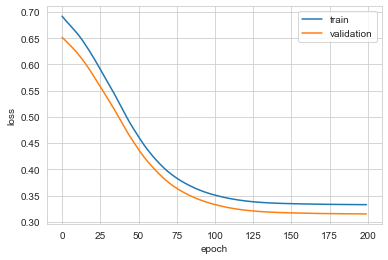

In [19]:
torch.save(model, "classifier.py")
plt.figure()

plt.plot(train_losses, label="train")
plt.plot(val_losses, label="validation")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()


In [20]:
test_loss = evaluate(best_model, test_src, test_tgt)
print('=' * 89)
print('| End of training | test loss {:5.2f} | test ppl {:8.2f}'.format(
    test_loss, math.exp(test_loss)))
print('=' * 89)




torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
| End of training | test loss  0.31 | test ppl     1.37


In [21]:
# save losses for plotting
import pandas as pd
df = pd.DataFrame({'train_loss':[float(l) for l in train_losses], 'val_loss': val_losses})
df.to_csv('classifier_losses.tsv', sep='\t', index=False)

In [66]:
def evaluate(eval_model, src, tgt):
    eval_model.eval() # Turn on the evaluation mode
    total_loss = 0.
    
    src_mask = model.generate_square_subsequent_mask(bptt).to(device)
    
    with torch.no_grad():
        for idx in range(0, src.size(0) - 1, eval_bptt):
            data, targets = get_batch(src, tgt, idx, eval_bptt)
            data, targets = data.to(device), targets.to(device)
            if data.shape[0] < eval_bptt:
                break

            src_mask = model.generate_square_subsequent_mask(data.size(0)).to(device)
            #src_pad_mask = (data == 0).bool().view(data.size(1), data.size(0))
        
            tgt_mask = model.generate_square_subsequent_mask(targets.size(0)).to(device)
            #tgt_pad_mask = (targets == 0).bool().view(targets.size(1), targets.size(0))    
            
            output = eval_model(data, src_mask, targets, tgt_mask)#, src_pad_mask, tgt_pad_mask)
            
            #output_trans = output.view(-1, ntokens)
            #target_trans = targets.view(-1, targets.size(1) * targets.size(0)).squeeze(0)
            
            #total_loss += len(data) * criterion(output, targets).item()
            
            
            print(output.view(2,-1).max(0).indices)
            #pred = output.view(-1,2)
            
            #print(pred)
            #print(pred.shape, targets.shape)
            
            #print(pred, targets)
            
            #pred = pred.max(1)
            
            #real = targets.max(1).indices
            
            #print(pred.shape, real.shape)
            
            
            #acc = (pred == real).sum().item() / pred.size(0)
            
        
            #print(acc)
            
            
            
    #return total_loss / (len(src) - 1)


evaluate(best_model, test_src, test_tgt)

len(test_tgt)

torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
tensor([0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0,
        0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1,
        1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0,
        1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1,
        1, 0, 0, 1], device='cuda:0')
torch.Size([50, 2, 80]) torch.Size([50, 291, 80]) torch.Size([50, 50])
tensor([0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0,
        0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1,
        1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0,
        1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1,
        0, 0, 1, 1], device='cuda:0')


107